# Ticket To Ride Network Analysis (Design Principles)

This notebook reads `board.json`, computes network statistics, and provides tools to edit/save the board.


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

board = json.loads(Path("board.json").read_text())
places = {p["id"]: p for p in board.get("places", [])}
roads = board.get("roads", [])

def save_board(path="board.json"):
    Path(path).write_text(json.dumps(board, indent=2))

print(f"Loaded {len(places)} cities, {len(roads)} routes")


Loaded 28 cities, 61 routes


In [2]:
# Build adjacency and edge weights
adj = {pid: set() for pid in places}
edges = []  # (a, b, weight)
for r in roads:
    ids = r.get("placeIds", [])
    if len(ids) != 2:
        continue
    a, b = ids
    w = int(r.get("spaceAmount", 0) or 0)
    adj.setdefault(a, set()).add(b)
    adj.setdefault(b, set()).add(a)
    edges.append((a, b, w))

degrees = {pid: len(neigh) for pid, neigh in adj.items()}
edge_weights = [w for _, _, w in edges if w > 0]

print("Degree range:", (min(degrees.values()), max(degrees.values())))
print("Edge weight range:", (min(edge_weights), max(edge_weights)) if edge_weights else (0, 0))


Degree range: (3, 8)
Edge weight range: (1, 8)


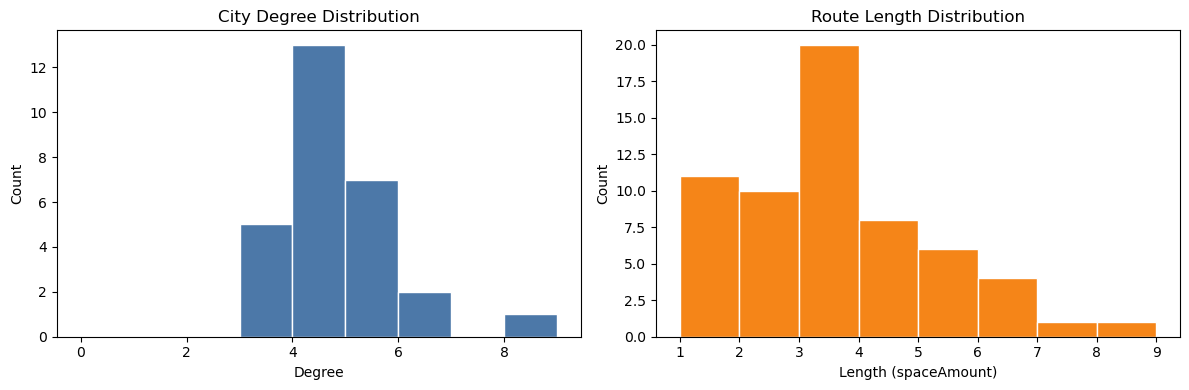

In [3]:
# Histograms: degree distribution and route lengths
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(degrees.values(), bins=range(0, max(degrees.values() or [0]) + 2),
             color="#4c78a8", edgecolor="white")
axes[0].set_title("City Degree Distribution")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Count")

axes[1].hist(edge_weights, bins=range(1, max(edge_weights or [1]) + 2),
             color="#f58518", edgecolor="white")
axes[1].set_title("Route Length Distribution")
axes[1].set_xlabel("Length (spaceAmount)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [4]:
# Shortest-path distances and eccentricity (unweighted graph)
from collections import deque

def bfs_distances(start):
    dist = {start: 0}
    q = deque([start])
    while q:
        cur = q.popleft()
        for nxt in adj.get(cur, []):
            if nxt not in dist:
                dist[nxt] = dist[cur] + 1
                q.append(nxt)
    return dist

eccentricity = {}
for pid in places:
    d = bfs_distances(pid)
    if len(d) != len(places):
        eccentricity[pid] = None
    else:
        eccentricity[pid] = max(d.values())

ecc_values = [v for v in eccentricity.values() if v is not None]
radius = min(ecc_values) if ecc_values else None
diameter = max(ecc_values) if ecc_values else None
center = [places[pid]["name"] for pid, v in eccentricity.items() if v == radius]
periphery = [places[pid]["name"] for pid, v in eccentricity.items() if v == diameter]

print("Radius:", radius)
print("Diameter:", diameter)
print("Center cities:", center)
print("Periphery cities:", periphery)


Radius: 3
Diameter: 5
Center cities: ['Long Beach', 'Boston']
Periphery cities: ['Fairbanks', 'Fort Worth', 'Washington DC', 'Seoul', 'Goesan', 'Izmir', 'Almaty', 'Yangon', 'Mawlamyine', 'Beijing']


In [5]:
# Degree centrality (simple)
n = len(places)
degree_centrality = {pid: (deg / (n - 1) if n > 1 else 0) for pid, deg in degrees.items()}

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top degree centrality:")
for pid, val in top_degree:
    print(places[pid]["name"], round(val, 3))


Top degree centrality:
Boston 0.296
Istanbul 0.222
Shanghai 0.222
Berkeley 0.185
Riverside 0.185
Long Beach 0.185
Washington DC 0.185
Tokyo 0.185
Tbilisi 0.185
Yerevan 0.185


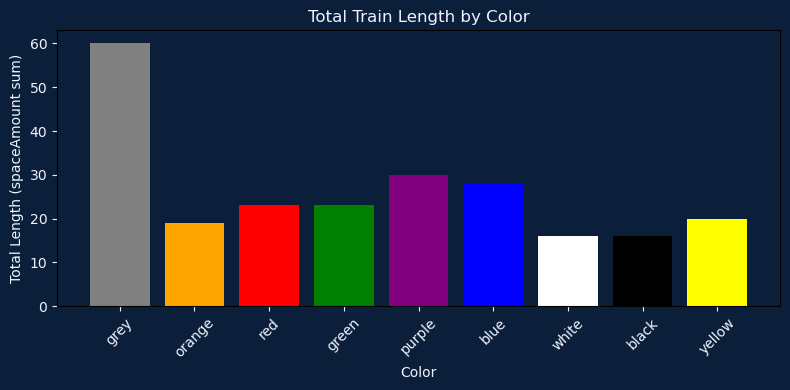

In [7]:
# Color statistics by total train count (spaceAmount per lane)
from collections import defaultdict

color_totals = defaultdict(int)
for r in roads:
    lanes = r.get("lanes", [])
    length = int(r.get("spaceAmount", 0) or 0)
    for lane in lanes:
        color = lane.get("colour", "grey")
        color_totals[color] += length

colors = list(color_totals.keys())
values = [color_totals[c] for c in colors]

fig, ax = plt.subplots(figsize=(8, 4))
fig.patch.set_facecolor("#0b1f3a")
ax.set_facecolor("#0b1f3a")
ax.bar(colors, values, color=colors)
ax.set_title("Total Train Length by Color", color="#f0f4ff")
ax.set_xlabel("Color", color="#f0f4ff")
ax.set_ylabel("Total Length (spaceAmount sum)", color="#f0f4ff")
plt.xticks(rotation=45, color="#f0f4ff")
ax.tick_params(colors="#f0f4ff")
plt.tight_layout()
plt.show()
